In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import KFold
import scipy.io as sio
import seaborn as sns
import scipy.optimize
import pickle
import pandas as pd
sns.set_context("talk")

# Import outside packages by changing the path
import sys, os
sys.path.append(os.path.abspath(os.path.join('..', '..', 'glmhmm')))
from glmhmm import glm, glm_hmm, utils, analysis
from glmhmm.utils import permute_states, find_best_fit, compare_top_weights
from glmhmm import visualize

# code from Brody Summer Project
sys.path.append(os.path.abspath(os.path.join('..', '..', 'LC_PWM_GLM-HMM/code')))
import io_utils, analysis_utils, plotting_utils

sns.set_context("talk")

In [2]:
### Fitting Iris' standard GLM-HMM models for IBL 3 features data for each animal from witten lab and until session 40

In [3]:
ibl_data_path = '../data_IBL'
dfAll = pd.read_csv(ibl_data_path + '/Ibl_processed.csv')
subjectsWitten = np.unique(dfAll[dfAll['lab'] == 'wittenlab']['subject'])
print(subjectsWitten)

['ibl_witten_02' 'ibl_witten_03' 'ibl_witten_04' 'ibl_witten_05'
 'ibl_witten_06' 'ibl_witten_07' 'ibl_witten_12' 'ibl_witten_13'
 'ibl_witten_14' 'ibl_witten_15' 'ibl_witten_16']


In [6]:
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)


def get_mouse_design(dfAll, subject, sessStop=-1, D=3):
    ''' 
    function to give design matrix x and output vector y for a given subject until session sessStpo
    '''
    data = dfAll[dfAll['subject']==subject]   # Restrict data to the subject specified

    p=5 # as used in Psytrack paper
    data['cL'] = np.tanh(p*data['contrastLeft'])/np.tanh(p) # tanh transformation of left contrasts
    data['cR'] = np.tanh(p*data['contrastRight'])/np.tanh(p) # tanh transformation of right contrasts

    # keeping first 40 sessions
    dateToKeep = np.unique(data['date'])[0:sessStop]
    dataTemp = pd.DataFrame(data.loc[data['date'].isin(list(dateToKeep))])


    # design and out matrix
    x = np.ones((dataTemp.shape[0], D)) # column 0 is bias
    x[:,1] = dataTemp['cL'] # cL = contrast left transformed 
    x[:,2] = dataTemp['cR'] # cR = contrast right transformed
    y = np.array(dataTemp['choice'])
    if (D>=4):
        # previous chioce
        # not taking into account first and last of each session (probably no effect of that)
        x[1:,3] = y[0:-1]
    if (D>=5):
        # previous rewarded
        # not taking into account first and last of each session (probably no effect of that)
        x[1:,4] = np.array(dataTemp['correctSide'])[0:-1]

    # session start indicies
    sessInd = [0]
    for date in dateToKeep :
        d = dataTemp[dataTemp['date']==date]
        for sess in np.unique(d['session']):
            dTemp = d[d['session'] == sess] 
            dLength = len(dTemp.index.tolist())
            sessInd.append(sessInd[-1] + dLength)
    
    return x, y, sessInd

In [11]:
for subject in ['ibl_witten_16']:
    x, y, sessInd = get_mouse_design(dfAll, subject, sessStop=-1, D=5)
    for K in [2,3]:
        
        # Set hyperparameters
        N = x.shape[0] # number of data/time points for the indirect pathway cohort
        C = 2 # number of observation classes
        D = x.shape[1] # number of GLM inputs (regressors)

        inits = 40 # set the number of initializations - Iris has 50
        maxiter = 250 # maximum number of iterations of EM to allow for each fit - Iris has 250
        tol = 1e-4

        # store values for each initialization
        lls_all = np.zeros((inits,maxiter))
        real_GLMHMMs = np.zeros((inits),dtype=object)

        # fit the model for each initialization
        for i in range(inits):
            print("Init ", i)
            real_GLMHMMs[i] = glm_hmm.GLMHMM(N,D,C,K,observations="bernoulli",gaussianPrior=1)
            # initialize the weights
            A_init, w_init, _ = real_GLMHMMs[i].generate_params(weights=['GLM',-2,2.2,x,y,1])
            # fit the model                     
            lls_all[i,:], A, w, pi = real_GLMHMMs[i].fit(y,x,A_init,w_init,maxiter=maxiter,tol=tol,sess=sessInd) 
            
            # Check to see that multiple fits achieve the same log-likelihood 
        fig, axes = plt.subplots(1,1)
        fig.set_size_inches(8, 4)
        topixs = visualize.plot_loglikelihoods(lls_all, maxdiff=0.15, ax=axes, startix=5) # colored in red are the ones (within maxdiff) to the best
        axes.set_title('log like')
            

        # find the initialization that led to the best fit
        bestix = find_best_fit(lls_all) 
        best_GLMHMM = real_GLMHMMs[bestix]

        # save the best fit - only for when large number of initializations and iterations!
        pickle.dump(best_GLMHMM, open(f'../data_IBL/IBL_{subject}_bestGLMHMM_D={D}_states-' + str(K) + '.pickle', 'wb'))

Init  0
Init  1
Init  2
Init  3
Init  4
Init  5
Init  6
Init  7
Init  8
Init  9
Init  10
Init  11
Init  12
Init  13
Init  14
Init  15
Init  16
Init  17
Init  18
Init  19
Init  20
Init  21
Init  22
Init  23
Init  24
Init  25
Init  26
Init  27
Init  28
Init  29
Init  30
Init  31
Init  32
Init  33
Init  34
Init  35
Init  36
Init  37
Init  38
Init  39
Init  0
Init  1
Init  2


[ 1  3  5 14 18 19 20 24]
[[[ 0.          2.80691371]
  [ 0.         -2.83475789]
  [ 0.         -0.90271782]]

 [[ 0.         -0.38889616]
  [ 0.         -2.49361159]
  [ 0.          1.84860961]]]


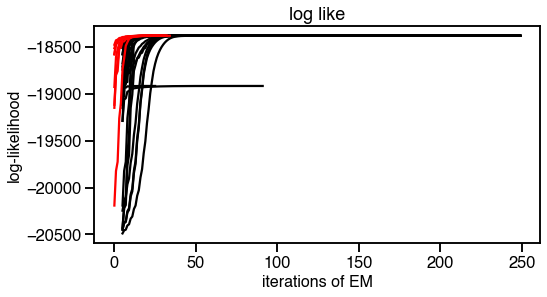

In [20]:
fig, axes = plt.subplots(1,1)
fig.set_size_inches(8, 4)
topixs = visualize.plot_loglikelihoods(lls_all[0:25], maxdiff=0.15, ax=axes, startix=5) # colored in red are the ones (within maxdiff) to the best
axes.set_title('log like')
print(topixs)

# find the initialization that led to the best fit
bestix = find_best_fit(lls_all[0:25]) 
best_GLMHMM = real_GLMHMMs[bestix]
print(best_GLMHMM.w)

[[1.]]
[[0.98796694 0.01203306]
 [0.02082319 0.97917681]]
[[9.97168184e-01 1.21630307e-03 1.61551317e-03]
 [2.82334812e-04 9.78140289e-01 2.15773765e-02]
 [6.98679873e-04 2.35067336e-02 9.75794586e-01]]


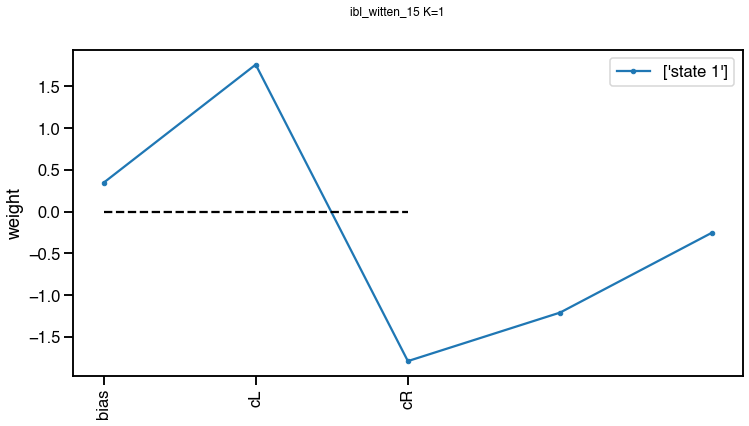

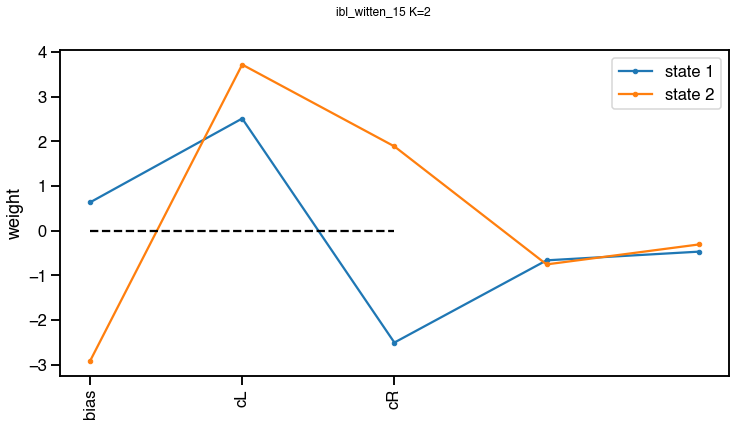

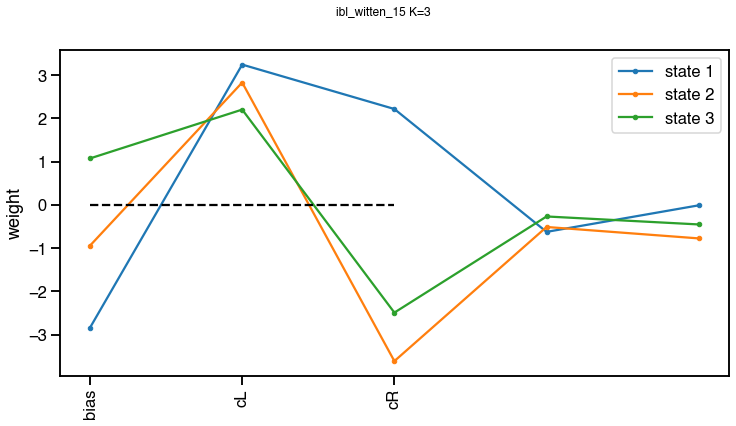

In [8]:
D = 5
for subject in  ['ibl_witten_15']: #['ibl_witten_15','ibl_witten_16', 'ibl_witten_05']:
    for K in [1,2,3]:
        bestGLMHMM = pickle.load(open(f'../data_IBL/IBL_{subject}_bestGLMHMM_D={D}_states-' + str(K) + '.pickle', 'rb'))
        print(bestGLMHMM.A)

        x, y, sessInd = x, y, sessInd = get_mouse_design(dfAll, subject, sessStop=-1, D=D)
        wTemp = bestGLMHMM.w
        wTemp[:,:,:] = - wTemp[:,:,:] # all weights have opposite sign in my code vs Iris'
        w = np.repeat(wTemp[np.newaxis], sessInd[-1], axis=0)
        np.save(f'../data_IBL/W_IBL_{subject}_bestGLMHMM-Iris_D={D}_{K}-state', w)
        np.save(f'../data_IBL/P_IBL_{subject}_bestGLMHMM-Iris_D={D}_{K}-state', bestGLMHMM.A)

        xlabels = ['bias', 'cL', 'cR']
        legend = []
        fig, axes = plt.subplots(1,figsize=(12,6))
        fig.suptitle(subject + " K=" + str(K))
        for i in range(1,K+1):
            legend.append('state ' + str(i))
        visualize.plot_weights(wTemp[:,:,-1],axes,xlabels=xlabels,switch=False,style='.-',error=None,label=legend) # w has shape K x D x C (but first column = 0 for C=2)
        axes.legend()


(38622,)
38622
Init  0
Init  1
Init  2
Init  3
Init  4
Init  5
Init  6
Init  7
Init  8
Init  9
Init  10
Init  11
Init  12
Init  13
Init  14
Init  15
Init  16
Init  17
Init  18
Init  19
Init  20
Init  21
Init  22
Init  23
Init  24
Init  25
Init  26
Init  27
Init  28
Init  29
Init  0
Init  1
Init  2
Init  3
Init  4
Init  5
Init  6
Init  7
Init  8
Init  9
Init  10
Init  11
Init  12
Init  13
Init  14
Init  15
Init  16
Init  17
Init  18
Init  19
Init  20
Init  21
Init  22
Init  23
Init  24
Init  25
Init  26
Init  27
Init  28
Init  29


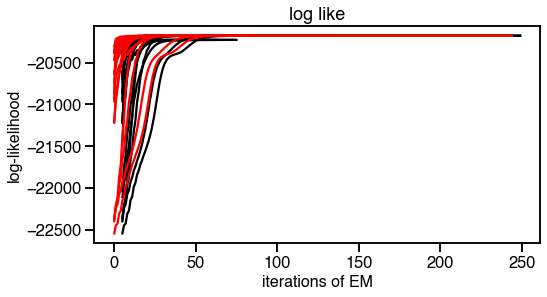

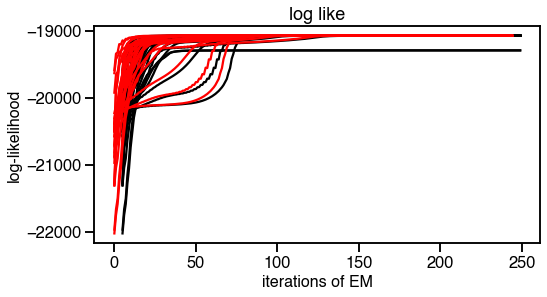

In [24]:
subject = 'ibl_witten_05'
x, y, sessInd = get_mouse_design(dfAll, subject)

for K in [2,3]:

    # Set hyperparameters
    N = x.shape[0] # number of data/time points for the indirect pathway cohort
    C = 2 # number of observation classes
    D = x.shape[1] # number of GLM inputs (regressors)

    inits = 30 # set the number of initializations - Iris has 50
    maxiter = 250 # maximum number of iterations of EM to allow for each fit - Iris has 250
    tol = 1e-4

    # store values for each initialization
    lls_all = np.zeros((inits,maxiter))
    real_GLMHMMs = np.zeros((inits),dtype=object)

    # fit the model for each initialization
    for i in range(inits):
        print("Init ", i)
        real_GLMHMMs[i] = glm_hmm.GLMHMM(N,D,C,K,observations="bernoulli",gaussianPrior=1)
        # initialize the weights
        A_init, w_init, _ = real_GLMHMMs[i].generate_params(weights=['GLM',-2,2.2,x,y,1])
        # fit the model                     
        lls_all[i,:], A, w, pi = real_GLMHMMs[i].fit(y,x,A_init,w_init,maxiter=maxiter,tol=tol,sess=sessInd) 
        
        # Check to see that multiple fits achieve the same log-likelihood 
    fig, axes = plt.subplots(1,1)
    fig.set_size_inches(8, 4)
    topixs = visualize.plot_loglikelihoods(lls_all, maxdiff=0.15, ax=axes, startix=5) # colored in red are the ones (within maxdiff) to the best
    axes.set_title('log like')
        

    # find the initialization that led to the best fit
    bestix = find_best_fit(lls_all) 
    best_GLMHMM = real_GLMHMMs[bestix]

    # save the best fit - only for when large number of initializations and iterations!
    pickle.dump(best_GLMHMM, open(f'../data_IBL/IBL_{subject}_bestGLMHMM__states-' + str(K) + '.pickle', 'wb'))